<a href="https://colab.research.google.com/github/mprksa/kubus5/blob/main/KNN5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/mprksa/Blocks2.git

Cloning into 'Blocks2'...
remote: Enumerating objects: 887, done.
remote: Counting objects: 100% (887/887), done.
remote: Compressing objects: 100% (873/873), done.
remote: Total 887 (delta 36), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (887/887), 1.82 GiB | 23.65 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Updating files: 100% (729/729), done.


In [2]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [3]:
# Fungsi untuk memuat gambar dan label
def load_data(image_folder, label_file, image_size=(256, 256)):
    images = []
    labels = []

    with open(label_file, 'r') as f:
        data = json.load(f)

    # Create a dictionary to map image_id to file_name
    image_id_to_filename = {image['id']: image['file_name'] for image in data['images']}
    # Create a dictionary to map category_id to category_name
    category_id_to_name = {category['id']: category['name'] for category in data['categories']}

    for annotation in data['annotations']:
        image_id = annotation['image_id']
        category_id = annotation['category_id']

        img_path = os.path.join(image_folder, image_id_to_filename[image_id])
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, image_size)
                img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                images.append(img_hsv.flatten())  # Flatten HSV image
                labels.append(category_id_to_name[category_id])

    return np.array(images), np.array(labels)

In [4]:
# Muat data
train_images, train_labels = load_data('Blocks2/train/images', 'Blocks2/train/labels.json')
test_images, test_labels = load_data('Blocks2/test/images', 'Blocks2/test/labels.json')
val_images, val_labels = load_data('Blocks2/validation/images', 'Blocks2/validation/labels.json')

# Tampilkan jumlah gambar
print(f"Jumlah gambar untuk pelatihan: {len(train_images)}")
print(f"Jumlah gambar untuk testing: {len(test_images)}")
print(f"Jumlah gambar untuk validasi: {len(val_images)}")

Jumlah gambar untuk pelatihan: 508
Jumlah gambar untuk testing: 72
Jumlah gambar untuk validasi: 144


In [13]:
# Training model dengan K-NN
def train_knn(train_features, train_labels, val_features, val_labels):
    knn = KNeighborsClassifier(n_neighbors=3)

    # Training model K-NN dengan data latihan
    knn.fit(train_features, train_labels)

    # Evaluasi pada data pelatihan dan validasi
    train_predictions = knn.predict(train_features)
    val_predictions = knn.predict(val_features)

    train_accuracy = accuracy_score(train_labels, train_predictions)
    val_accuracy = accuracy_score(val_labels, val_predictions)

    print(f"Akurasi Pelatihan: {train_accuracy:.4f} | Akurasi Validasi: {val_accuracy:.4f}")

    return knn, train_accuracy, val_accuracy # Return accuracies as well

In [14]:
# Ekstraksi fitur untuk setiap dataset (gunakan flatten untuk K-NN)
def extract_features(images):
    return images

train_features = extract_features(train_images)
test_features = extract_features(test_images)
val_features = extract_features(val_images)

# Training model
knn_model, train_accuracy, val_accuracy = train_knn(train_features, train_labels, val_features, val_labels)

Akurasi Pelatihan: 0.8917 | Akurasi Validasi: 0.4167


In [15]:
# Create lists to store accuracies (initialize with first values)
train_accuracies = [train_accuracy]
val_accuracies = [val_accuracy]

In [16]:
# Evaluasi model K-NN
train_predictions = knn_model.predict(train_features)
test_predictions = knn_model.predict(test_features)
val_predictions = knn_model.predict(val_features)

In [17]:
# Evaluasi akurasi
train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)
val_accuracy = accuracy_score(val_labels, val_predictions)

print(f"Akurasi Pelatihan: {train_accuracy:.4f}")
print(f"Akurasi Testing: {test_accuracy:.4f}")
print(f"Akurasi Validasi: {val_accuracy:.4f}")

Akurasi Pelatihan: 0.8917
Akurasi Testing: 0.2778
Akurasi Validasi: 0.4167


In [ ]:
# Simpan model K-NN
joblib.dump(knn_model, 'knn_model.pkl')

In [19]:
# Hitung rata-rata H, S, dan V untuk setiap kelas
def calculate_class_hsv_means(features, labels):
    unique_labels = np.unique(labels)
    class_hsv_means = {}

    for label in unique_labels:
        class_indices = np.where(labels == label)
        class_features = features[class_indices]
        class_hsv_means[label] = np.mean(class_features, axis=0)

    return class_hsv_means

train_class_hsv_means = calculate_class_hsv_means(train_features, train_labels)

In [22]:
# Tampilkan dalam bentuk tabel menggunakan pandas
# Restructure the dictionary for pandas DataFrame
restructured_data = {
    'Rata-rata H': [v[0] for v in train_class_hsv_means.values()],
    'Rata-rata S': [v[1] for v in train_class_hsv_means.values()],
    'Rata-rata V': [v[2] for v in train_class_hsv_means.values()]
}

df = pd.DataFrame(restructured_data, index=train_class_hsv_means.keys())
print(df)

        Rata-rata H  Rata-rata S  Rata-rata V
biru      19.712871    43.306931   154.841584
hitam     20.313725    40.725490   165.833333
kuning    23.705882    37.039216   141.823529
merah     20.564356    36.059406   160.712871
putih     20.029412    41.607843   143.558824


In [23]:
# Tampilkan classification report dan confusion matrix untuk validasi
val_class_report = classification_report(val_labels, val_predictions)
val_conf_matrix = confusion_matrix(val_labels, val_predictions)

In [24]:
print("Classification Report untuk Validasi:")
print(val_class_report)

Classification Report untuk Validasi:
              precision    recall  f1-score   support

        biru       0.58      0.66      0.61        29
       hitam       0.80      0.69      0.74        29
      kuning       0.21      0.11      0.14        28
       merah       0.14      0.14      0.14        29
       putih       0.33      0.48      0.39        29

    accuracy                           0.42       144
   macro avg       0.41      0.41      0.40       144
weighted avg       0.41      0.42      0.41       144



In [25]:
print("Confusion Matrix untuk Validasi:")
print(val_conf_matrix)

Confusion Matrix untuk Validasi:
[[19  0  1  1  8]
 [ 0 20  0  0  9]
 [ 1  0  3 20  4]
 [ 8  0  9  4  8]
 [ 5  5  1  4 14]]


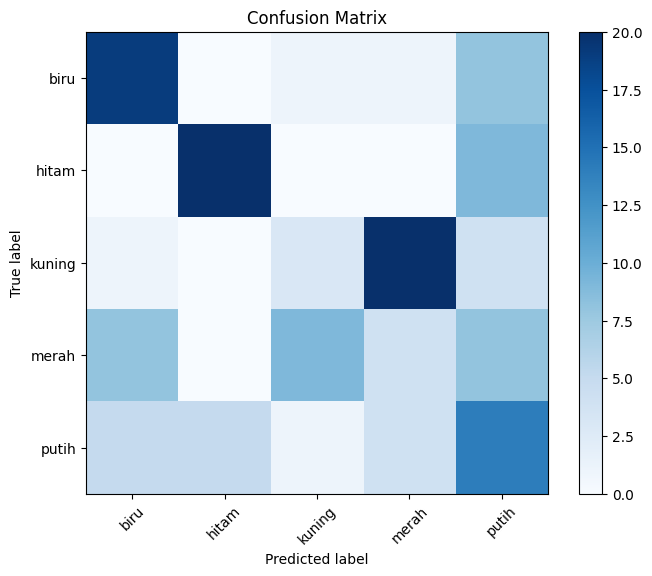

In [26]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(val_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(train_labels)))
plt.xticks(tick_marks, np.unique(train_labels), rotation=45)
plt.yticks(tick_marks, np.unique(train_labels))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()